# Graded exercise: Modeling neurons

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Problem description

In this exercise you should find the relationship between the **diameter of a dendrite and the attenuation of synaptic EPSPs.**

An EPSP is the potential difference caused by the activation of a synapse. Below you find code that shows you the synaptic attenuation. By putting the synapse further and further from the soma, EPSPs become smaller and smaller, i.e. they are attenuated by traveling through the dendrite.

Below you find the code to calculate the [exponential decay constant](https://en.wikipedia.org/wiki/Exponential_decay) of the EPSP amplitude.

Now try to find the relationship between the (uniform) diameter of the dendrite, and the synaptic attenuation. For this vary the diameter (use 'for' loop) between .1 -> 10 micron.

You can use:
diam_range = numpy.linspace(.1, 10.0, 20)

Save the exponential decay constant for each diameter, and plot the log of the exponential decay constant (on Y-axis) against the log of diam_range (on X-axis).

This should form a linear relationship. Use numpy.polyfit to fit a line to this relationship.

a, b = numpy.polyfit(x, y, 1)

and send us the slope parameter 'a' of the fit.

In [1]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import

%matplotlib inline

In [ ]:
!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

In [29]:
!pip -q install --upgrade --pre -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

ERROR: Could not find a version that satisfies the requirement single-cell-mooc-client
ERROR: No matching distribution found for single-cell-mooc-client
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
# Init
import neuron
import numpy
import matplotlib.pyplot as plt

neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

In [4]:
# Define soma
soma = neuron.h.Section(name='soma')
soma.L = 40
soma.diam = 40
soma.insert('hh');
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2
soma.el_hh = -65 # Reversal potential leak current, mV
soma.gkbar_hh = 0.0 # in S/cm^2
soma.gnabar_hh = 0.0

# Define dendrite
dend = neuron.h.Section(name='dend')
dend.connect(soma, 0)
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2
dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0
dend.L = 400 # micron
dend.diam = 1.0 # micron
dend.nseg = 51 # number of segments in the dendritic section
dend.Ra = 200

In [5]:
# Record voltage
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(dend(0)._ref_v);

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

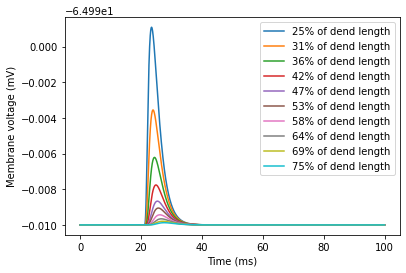

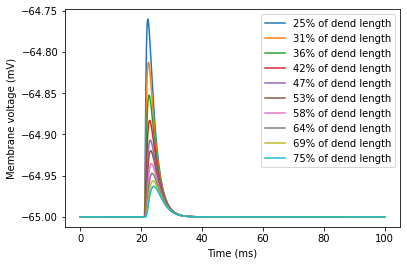

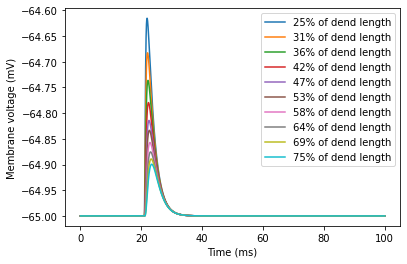

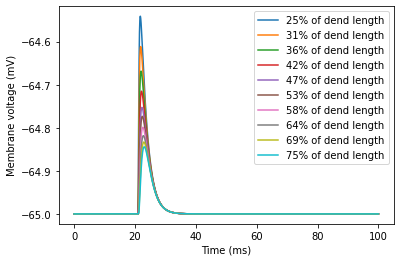

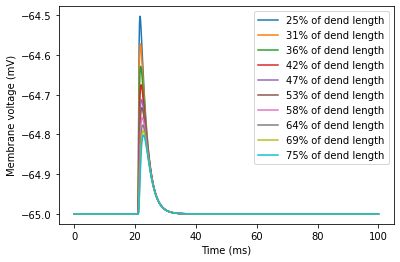

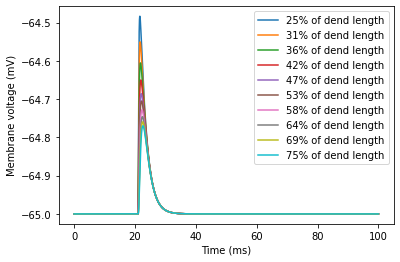

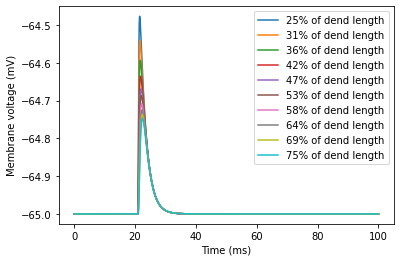

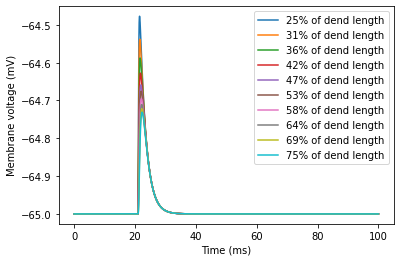

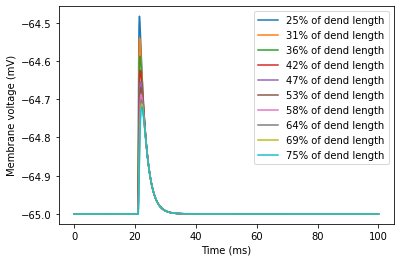

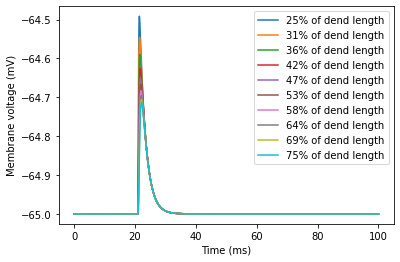

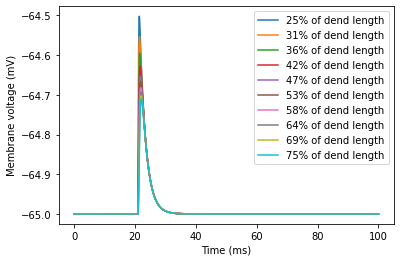

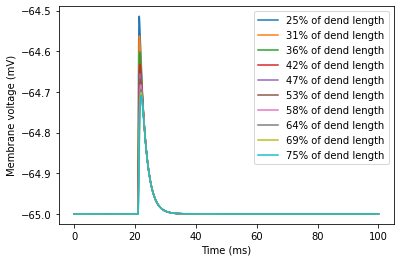

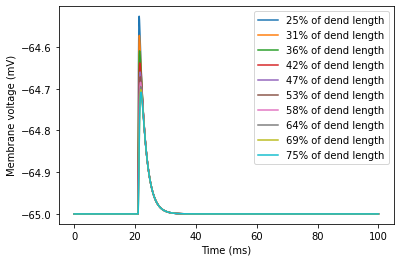

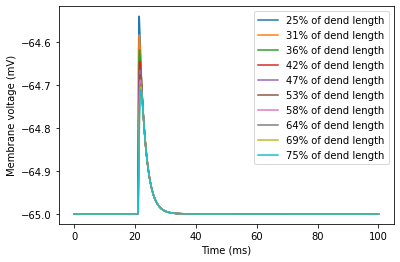

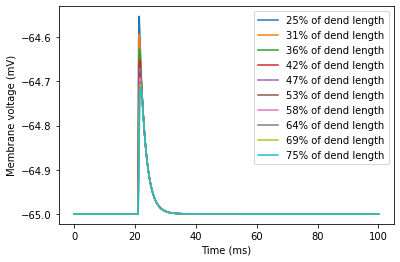

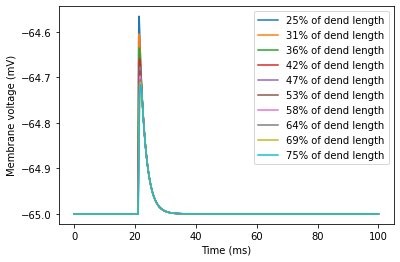

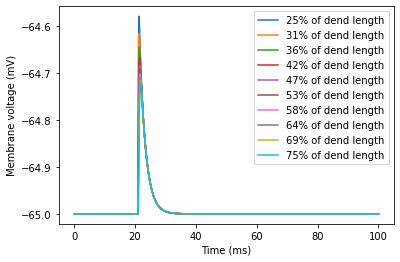

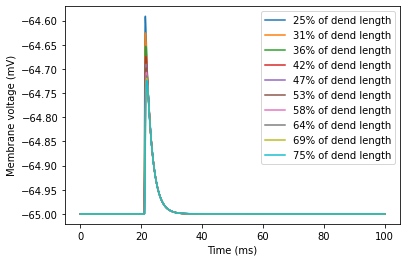

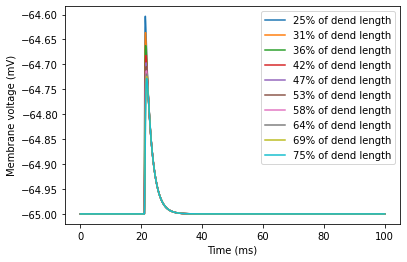

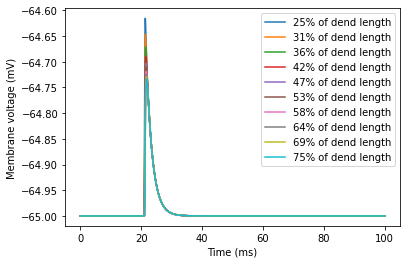

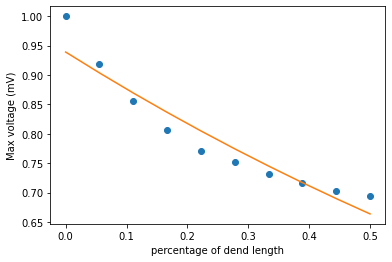

Exponential decay constant of EPSPs: 0.693803


In [16]:
voltage_dist = {}
atts = []

dend.diam = 0.1
diam_range = numpy.linspace(.1, 10.0, 20)
exp_const_arr = []

# Take distance from 25% -> 75% of dendrite to avoid boundary effects
distance_range = numpy.linspace(0.25, .75, 10)

# Add synapse 
for diam_r in diam_range: 
    dend.diam = diam_r
    for syn_location in distance_range:
        expsyn = neuron.h.ExpSyn(syn_location, sec=dend) 

        netstim = neuron.h.NetStim()
        netstim.interval = 1
        netstim.number = 1
        netstim.start = 20
        netstim.noise = 0

        netcon = neuron.h.NetCon(netstim, expsyn)
        netcon.weight[0] = .01
        neuron.h.tstop = 100
        neuron.h.run()

        voltage_dist[syn_location] = numpy.array(voltage)


# Plot voltages for synapse at different distances
    for distance in distance_range:
        plot_tv(time, voltage_dist[distance], show=False, label='%.0f%% of dend length' % (distance*100))
    plt.legend()
    plt.show()

    # Store the EPSP sizes
    epsp_size = []
    for distance in distance_range:
        # Get the EPSP size by subtracting the min (baseline) voltage from the max voltage
        epsp_size.append(max(voltage_dist[distance])-min(voltage_dist[distance]))


    # Bring x[0] to 0.0
    x = distance_range-distance_range[0]

    # Normalize
    y = epsp_size/epsp_size[0]


    # Fit a linear line to log plot
    a, b = numpy.polyfit(x, numpy.log(y), 1)

    exp_decay_constant = -a
    exp_const_arr.append(exp_decay_constant)

# Plot the data
plt.plot(x, y, 'o')
# Plot the fit
plt.plot(x, numpy.exp(a*x + b))

plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

print('Exponential decay constant of EPSPs: %f' % exp_decay_constant)

In [17]:
print(exp_const_arr)

[8.833480690308058, 3.7136593460536425, 2.6832029235989014, 2.1582001169945695, 1.8289444141710909, 1.600869560455349, 1.4332725806020847, 1.3043959143376154, 1.201772086021983, 1.117785818624181, 1.0478375306270584, 0.9881462301244176, 0.9364178836506719, 0.890475289746294, 0.8498647964678768, 0.8131949458185763, 0.7796280298939943, 0.7487608487414616, 0.7209016601345197, 0.6938030111853708]


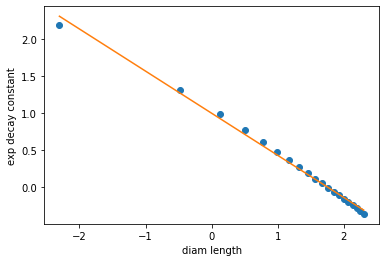

-0.5686254495906407 x +  0.9941848470620254


In [23]:
plt.plot(numpy.log(diam_range), numpy.log(exp_const_arr), 'o')
a, b = numpy.polyfit(numpy.log(diam_range), numpy.log(exp_const_arr), 1)
plt.plot(numpy.log(diam_range), a*numpy.log(diam_range)+b)
plt.xlabel('diam length')
plt.ylabel('exp decay constant')
plt.show()
print(a, "x + ", b)

After finishing the exercise, send us in the widget below the 'a' parameter returned by polyfit (as seen in the example above).
So an example answer is "0.1", without the double quotes.

In [26]:
import single_cell_mooc_client as sc_mc
submission_widget = sc_mc.Submission(-0.5686)

ModuleNotFoundError: No module named 'single_cell_mooc_client'